In [118]:
import torch

In [119]:
import os
import sys
# import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [120]:
#Helper function
import os
import datetime
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# from utils.log_event import fn_log_event


# verify if the directory exists
def fn_dir_exists(_dir):
    '''
    Args:
    	_dir: path if a directory
     '''

    res = os.path.exists(_dir)

    fn_log_event ('-- Directory "{}" exist : {}'.format(_dir, res), 'debug')

    if not res:

        fn_log_event ('-- Directory "{}" does not exists.'.format(_dir), 'debug')

        sys.exit('-- Directory "{}" does not exists.'.format(_dir))

    return res



def fn_file_exists(_file):
    '''
        verify if the file exists
    '''
    res = os.path.exists(_file)

    fn_log_event ('-- File "{}" exist : {}'.format(_file, res), 'debug')

    if not res:

        fn_log_event ('-- File "{}" does not exists.'.format(_file), 'debug')

        sys.exit('-- File "{}" does not exists.'.format(_file))

    return res


###-----------------------------
### Verify or create a directory
###-----------------------------
def fn_verify_dir(_path : str):
    '''
    Arg:
        path: path to verify the directory
    returns:
        create dir if it does not exists
    '''
    if os.path.exists(_path): # check if the path exists. Maybe a file or a folder

        print(_path, ' exists') # advised the user

    else:

        os.makedirs(_path) # create the path

        print("Created folder : ", _path)

###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]

    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')

    plt.tight_layout()



###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')

    plt.tight_layout()



###---------------------------------------------------
### Plot count of classes in training and testing sets
###---------------------------------------------------
def fn_plot_labels(tr_ds, ts_ds, class_names = None):

    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure and axes
    fig, axes = plt.subplots(1,2, figsize = (15,5))

    # get names of the classes
    if not class_names:
        tr_class_names = tr_ds.class_names
        ts_class_names = tr_ds.class_names

    # pick first axis
    ax = axes[0]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in tr_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1

    # bar plot
    ax.bar(tr_class_names, [class_counts.get(i, 0) for i in range(len(tr_class_names))],
           align='center',color = 'DarkBlue', alpha = 0.7)

    # add title
    ax.set_title('Training Set')

    # grids make it look good
    ax.grid()


    #pick second image
    ax = axes[1]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in ts_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1

    # bar plot
    ax.bar(ts_class_names, [class_counts.get(i, 0) for i in range(len(ts_class_names))],
           align='center',color = 'orange', alpha = 0.7)

    # add title
    ax.set_title('Test Set')


    # grids make it look good
    ax.grid()

    # fit the subplot(s) in to the figure area
    plt.tight_layout()

    # display all open figures
    plt.show()

def fn_convert_timestamp(tstr):
    '''
        Function to conver string of form "2015-11-12 1444"
    '''

    return datetime.strptime(tstr, "%Y-%m-%d_%H%M")

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())

    fig, ax = plt.subplots(figsize = (6,6))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


In [121]:
inpDir = '../../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 51 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [122]:
data_df = pd.read_csv("fifa_2019.csv")
data_df

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,19,https://cdn.sofifa.org/players/4/19/238813.png,England,https://cdn.sofifa.org/flags/14.png,47,65,Crewe Alexandra,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,18203,243165,N. Christoffersson,19,https://cdn.sofifa.org/players/4/19/243165.png,Sweden,https://cdn.sofifa.org/flags/46.png,47,63,Trelleborgs FF,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,18204,241638,B. Worman,16,https://cdn.sofifa.org/players/4/19/241638.png,England,https://cdn.sofifa.org/flags/14.png,47,67,Cambridge United,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,18205,246268,D. Walker-Rice,17,https://cdn.sofifa.org/players/4/19/246268.png,England,https://cdn.sofifa.org/flags/14.png,47,66,Tranmere Rovers,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


In [123]:
data_df.shape

(18207, 89)

In [124]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [125]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 89, dtype: int64

In [126]:
data_df["Position"].isnull().sum()

60

In [127]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [128]:
for col in data_df.columns:
    print(f'{col}: {data_df[col].unique()}')

Unnamed: 0: [    0     1     2 ... 18204 18205 18206]
ID: [158023  20801 190871 ... 241638 246268 246269]
Name: ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age: [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo: ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality: ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' 'Switze

In [129]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18147.0,9089.239599,5257.923360,0.0,4536.5,9076.0,13662.5,18206.0
ID,18147.0,214279.818868,29970.319078,16.0,200305.5,221740.0,236512.5,246620.0
Age,18147.0,25.121122,4.669796,16.0,21.0,25.0,28.0,45.0
Overall,18147.0,66.253926,6.913320,46.0,62.0,66.0,71.0,94.0
Potential,18147.0,71.324076,6.132286,48.0,67.0,71.0,75.0,95.0
Special,18147.0,1598.002645,272.882706,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18147.0,1.113297,0.394150,1.0,1.0,1.0,1.0,5.0
Weak Foot,18147.0,2.947154,0.660498,1.0,3.0,3.0,3.0,5.0
Skill Moves,18147.0,2.361492,0.756274,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [130]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [131]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

<ipython-input-131-8efaa3a3d008>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")


In [132]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [133]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [134]:
#features_df = data_df.drop('Position',axis=1)
labels = data_df['Position'].to_numpy()

In [135]:
# splitting in train ans test datasets
train_df, test_df = train_test_split(data_df,
                                     stratify=data_df['Position'],
                                     test_size=TEST_SIZE,
                                     random_state=RANDOM_STATE )

train_df.shape, test_df.shape

((14517, 34), (3630, 34))

In [136]:
'''Using sigleton design pattern'''

class GlobalScaler:
  _instance = None

  def __init__ (self):
    if GlobalScaler._instance is not None:
      raise Exception ("GlobalScaler class is a singleton.")

    self.scaler = StandardScaler()

  @classmethod
  def get_instance(cls):
    if cls._instance is None:
      cls._instance = GlobalScaler()
    return cls._instance



In [137]:
class FifaDS(Dataset):
  globalScaler = GlobalScaler.get_instance()  #private instance variable

  def __init__ (self,
                dataframe: pd.DataFrame,
                device : str = device,
                is_train = True,
                label_col = None
                ):
    self.df = dataframe
    self.device = device
    self.is_train = is_train
    self.scaler = self.globalScaler.scaler
    self.label_col = label_col

    self.labels = self.df[label_col].to_numpy()
    X = self.df.drop(label_col, axis=1)

    if self.is_train:
      self.features = self.scaler.fit_transform(X) #fit transform
    else:
      self.features = self.scaler.transform(X) #transform only

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    #extract features and label from the dataframe row
    features = self.features[index]
    label = self.labels[index]

    #convert to pytorch tensors
    features = torch.tensor(features,
                            dtype=torch.float32,
                            device=self.device)
    label = torch.tensor(label,
                         dtype=torch.int64,
                         device=self.device)

    return features, label


In [138]:
label_col = 'Position'

train_ds = FifaDS(train_df, is_train=True, label_col = label_col)

test_ds = FifaDS(test_df, is_train=False, label_col = label_col)

In [139]:
next(iter(train_ds))

(tensor([ 0.8440,  0.2736, -0.5224,  0.2311,  0.2971, -0.2802, -0.9055, -0.7692,
          0.0364,  0.6969,  0.5615,  0.6422, -0.3119,  0.4269,  0.0910, -0.0058,
         -0.0157, -0.2691,  0.1495, -0.3957, -1.5856,  0.5660, -0.4513,  0.9238,
         -0.5824, -1.3197, -1.4632, -1.5835, -0.3178, -0.5550, -0.3775, -0.2574,
         -0.3184], device='cuda:0'),
 tensor(3, device='cuda:0'))

In [140]:
input_shape = train_df.shape[1] -1
input_shape

33

In [141]:
class Model(nn.Module):

    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,16)
        self.activ1 = nn.SiLU()
        self.layer2 = nn.Linear(16, 4)

    def forward(self, x):
        x = self.layer1(x)  #forward pass in layer1
        x = self.activ1(x)
        x = F.softmax(self.layer2(x), dim = 1)
        return x

net = Model(input_dim = input_shape).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=33, out_features=16, bias=True)
  (activ1): SiLU()
  (layer2): Linear(in_features=16, out_features=4, bias=True)
)


In [142]:
train_loader = DataLoader(train_ds,
                          batch_size = BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(test_ds,
                          batch_size = BATCH_SIZE,
                          shuffle=True)

In [143]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):

    # Training loop
    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(train_loader):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)

        preds = torch.argmax(outputs, dim = 1)

        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

        batch_loss.backward()

        optimizer.step()

        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)

    train_loss /= len(train_ds)
    train_acc /= len(train_ds)

    loss.append(train_loss)
    acc.append(train_acc)

    # Testing loop
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():

        for data in test_loader:

            inputs, labels = data

            outputs = net(inputs)

            preds = torch.argmax(outputs, dim = 1)

            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)

        test_loss /= len(test_ds)
        test_acc /= len(test_ds)

        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)

    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:1.0348, test:0.9216 | Acc - train:0.7581, test:0.8281
At epoch 5 | Loss - train:0.8696, test:0.8785 | Acc - train:0.8759, test:0.8647
At epoch 10 | Loss - train:0.8631, test:0.8717 | Acc - train:0.8801, test:0.8697
At epoch 15 | Loss - train:0.8597, test:0.8691 | Acc - train:0.8856, test:0.8722
At epoch 20 | Loss - train:0.8577, test:0.8664 | Acc - train:0.8857, test:0.8758
At epoch 25 | Loss - train:0.8561, test:0.8661 | Acc - train:0.8883, test:0.8758
At epoch 30 | Loss - train:0.8548, test:0.8643 | Acc - train:0.8898, test:0.8771
At epoch 35 | Loss - train:0.8533, test:0.8640 | Acc - train:0.8914, test:0.8777
At epoch 40 | Loss - train:0.8525, test:0.8625 | Acc - train:0.8912, test:0.8807
At epoch 45 | Loss - train:0.8516, test:0.8635 | Acc - train:0.8923, test:0.8769
At epoch 50 | Loss - train:0.8510, test:0.8649 | Acc - train:0.8938, test:0.8782


In [144]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.034775,0.921622,0.758146,0.828099
1,1,0.899376,0.895316,0.851829,0.850138
2,2,0.882487,0.884803,0.865055,0.858953
3,3,0.875440,0.880067,0.871323,0.863361
4,4,0.872391,0.877523,0.872977,0.864187


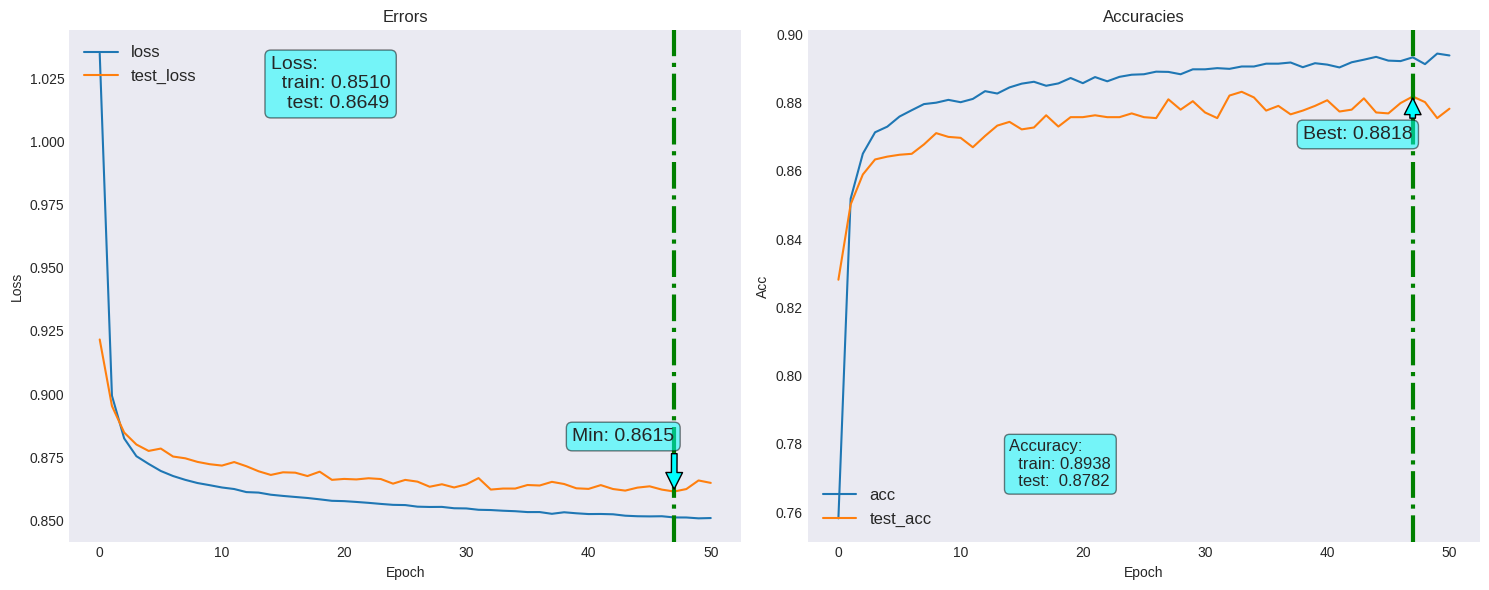

In [146]:
fn_plot_torch_hist(loss_df)

In [147]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):

    inputs, labels = data

    outputs = net(inputs)

    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [148]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.94      0.93      4693
           2       0.86      0.86      0.86      5470
           3       0.85      0.81      0.83      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.91     14517
weighted avg       0.89      0.89      0.89     14517



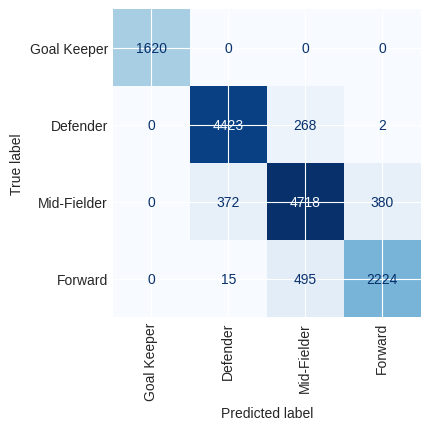

In [149]:
cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

## Performance on test data

In [151]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):

    inputs, labels = data

    outputs = net(inputs)

    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [152]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.91      0.94      0.93      1173
           2       0.84      0.84      0.84      1368
           3       0.82      0.77      0.79       684

    accuracy                           0.88      3630
   macro avg       0.89      0.89      0.89      3630
weighted avg       0.88      0.88      0.88      3630



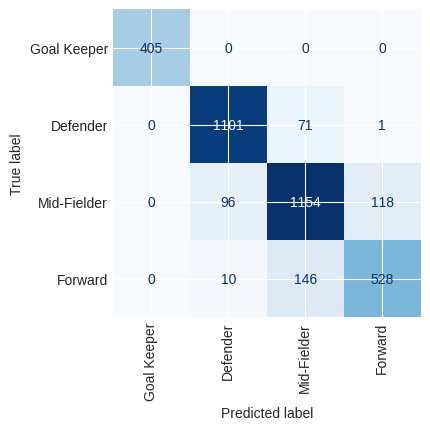

In [153]:
cmt  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cmt,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();